## 1. Load all relevant python modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import gzip
import json
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
from datasets import load_dataset

import warnings
warnings.filterwarnings("ignore")


c:\Users\gotta\OneDrive\Desktop\CS7643 Deep Learning\Final_Project\CS7643_Final_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load a subset (Electronics category)
dataset = load_dataset("amazon_polarity", split="train[:20000]")  # ~20k records

# View a sample record
print(dataset[0])

{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}


In [3]:
# Convert to pandas DataFrame
df = dataset.to_pandas()

# Take a quick look
df.head()

,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [1]:
df.columns

NameError: name 'df' is not defined

label      0
title      0
content    0
dtype: int64


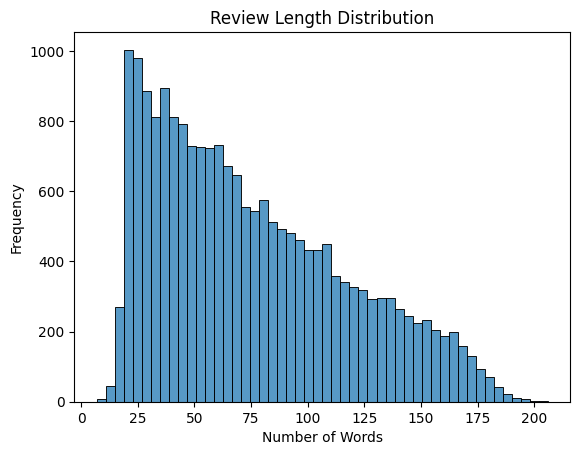

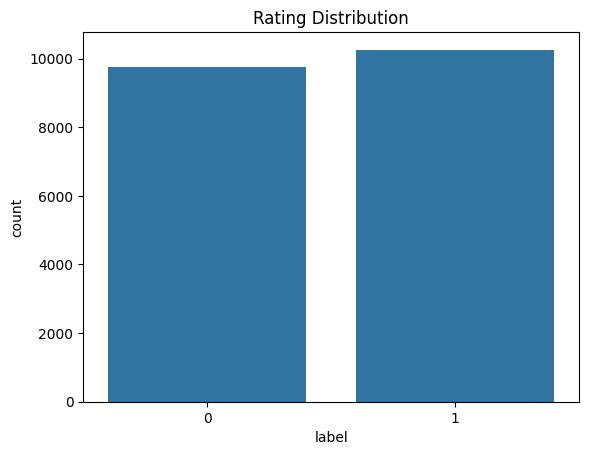

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Check nulls
print(df.isnull().sum())

# 2. Sample distribution of categories (if present)
if 'category' in df.columns:
    plt.figure(figsize=(12,6))
    df['category'].value_counts().nlargest(10).plot(kind='bar')
    plt.title("Top 10 Product Categories")
    plt.xlabel("Category")
    plt.ylabel("Frequency")
    plt.show()

# 3. Review text length distribution
df['review_length'] = df['content'].apply(lambda x: len(str(x).split()))
sns.histplot(df['review_length'], bins=50)
plt.title('Review Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# 4. Class balance for ratings or sentiment
sns.countplot(x='label', data=df)
plt.title('Rating Distribution')
plt.show()


In [5]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# Create tokenized dataset
def tokenize_function(example):
    return tokenizer(example['content'], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [6]:
from datasets import DatasetDict

# Split the dataset
dataset_dict = tokenized_dataset.train_test_split(test_size=0.2)

train_dataset = dataset_dict['train']
test_dataset = dataset_dict['test']


In [7]:
from transformers import TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

In [9]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()


  4%|▍         | 118/3000 [17:32<6:33:41,  8.20s/it]

KeyboardInterrupt: 